***Libraries***

In [4]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# ***Code***

In [ ]:

# Clean Data
data_dir = r"I:/Programmer/DataSets/CatVsDog"
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print(f'Number of skipped images: {num_skipped}')

# Preprocessing
IMG_SIZE = 160
BATCH_SIZE = 32

# Preprocessing
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset= 'training',
    seed= 42,
    image_size= (IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset= "validation",
    seed= 42,
    image_size= (IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
)

# Fanctions
def Formating(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image, label


# Pipeline
FormatedTrain = train_ds.shuffle(1000).map(Formating).prefetch(tf.data.AUTOTUNE)
FormatedTest = test_ds.map(Formating).prefetch(tf.data.AUTOTUNE)


Number of skipped images: 0
Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [6]:
base_model = MobileNetV3Large(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable=True

Input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

callback = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('DogvsCatModel.keras', monitor='val_accuracy', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]

DataAS = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomBrightness(0.1),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(0.05)
])

x = DataAS(Input)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

Output = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(Input, Output)

for i in base_model.layers[:50]:
    i.trainable=False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\iliya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\applications\mobilenet_v3.py:519: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 2,945,497 (11.24 MB)

 Non-trainable params: 51,816 (202.41 KB)

In [23]:
history = model.fit(FormatedTrain, epochs=30, validation_data=FormatedTest, callbacks=callback)

Epoch 1/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 97s 150ms/step - accuracy: 0.6068 - loss: 0.6304 - val_accuracy: 0.5888 - val_loss: 0.6525 - learning_rate: 1.0000e-04
Epoch 2/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - accuracy: 0.6532 - loss: 0.5548 - val_accuracy: 0.7472 - val_loss: 0.4730 - learning_rate: 1.0000e-04
Epoch 3/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - accuracy: 0.6654 - loss: 0.5321 - val_accuracy: 0.8469 - val_loss: 0.3278 - learning_rate: 1.0000e-04
Epoch 4/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 83s 139ms/step - accuracy: 0.6827 - loss: 0.5108 - val_accuracy: 0.8480 - val_loss: 0.3310 - learning_rate: 1.0000e-04
Epoch 5/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.6851 - loss: 0.4996 - val_accuracy: 0.8414 - val_loss: 0.3752 - learning_rate: 1.0000e-04
Epoch 6/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 84s 141ms/step - accuracy: 0.6913 - loss: 0.4836 - val_accuracy: 0.8546 - val_loss: 0.3320 - learning_rate: 1.0000e-04
Epoch 7/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 82s 13

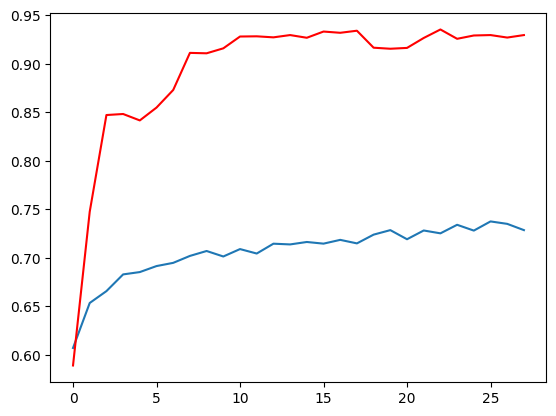

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='red')
plt.show()

In [25]:
model.evaluate(FormatedTest)

147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9293 - loss: 0.1720


[0.17195837199687958, 0.9293339252471924]

In [3]:
from tensorflow.keras import models

In [7]:
model = models.load_model('DogvsCatModel.keras')
model.evaluate(FormatedTest)

147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9351 - loss: 0.1595


[0.15946172177791595, 0.9350982308387756]